# NPS Agent with LangGraph + MLflow Tracing

Automatic tracing with `mlflow.langchain.autolog()` for a ReAct agent equipped with NPS API tools in LangGraph.

**Prerequisites:**
- NPS MCP server running on `localhost:3005` (see `nps_mcp_server.py` in the `agents_tracing-eval_mlflow/nps_agent/` folder)
- `OPENAI_API_KEY` set in `.env` file 

## Configuration

Load environment variables and configure MLflow tracing.

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configuration
NPS_MCP_URL = "http://localhost:3005/sse"
OPENAI_MODEL = "gpt-4o"

# TODO : This example works with llamastack chat-completions but 
# throws pydantic related issues with llamastack Responses

## MLflow Setup

Configure MLflow tracking and enable LangChain auto-tracing.

**Important:** Call `mlflow.langchain.autolog()` AFTER importing LangChain/LangGraph modules.

In [2]:
import mlflow

# Set up MLflow tracking URI (local SQLite database)
db_path = os.path.join(os.getcwd(), "mlflow.db")
mlflow.set_tracking_uri(f"sqlite:///{db_path}")

# Set experiment name
mlflow.set_experiment("langgraph-nps-agent-bug")

print(f"MLflow tracking URI: sqlite:///{db_path}")
print(f"Experiment: langgraph-nps-agent")

/Users/rranabha/red_hat_repos/agents/examples/langgraph-tracing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026/02/17 12:33:41 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/17 12:33:41 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/17 12:33:41 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/17 12:33:41 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/17 12:33:41 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/17 12:33:41 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/17 12:33:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/17 12:33:41 INFO alembic.runtime.migration: Will assume 

MLflow tracking URI: sqlite:////Users/rranabha/red_hat_repos/agents/examples/langgraph-tracing/mlflow.db
Experiment: langgraph-nps-agent


In [3]:
# Import LangChain/LangGraph modules first
from langchain_openai import ChatOpenAI
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display

# Enable autolog AFTER imports
mlflow.langchain.autolog(run_tracer_inline=False)
print("MLflow LangChain autolog enabled")

MLflow LangChain autolog enabled


## Connect to MCP Server

Initialize the MCP client and fetch available tools from the NPS MCP server.

In [ ]:
# Initialize MCP client
# https://python.langchain.com/docs/integrations/tools/mcp/
# Note: SSE transport is deprecated by MCP project. Prefer Streamable HTTP or stdio when available.
client = MultiServerMCPClient(
    {
        "nps": {
            "transport": "sse",
            "url": NPS_MCP_URL,
        }
    }
)

# Get tools from MCP server
tools = await client.get_tools()
print(f"Loaded {len(tools)} tools from MCP server:")
for tool in tools:
    print(f"  - {tool.name}: {tool.description[:60]}...")

# Print full tool definitions
print("\n--- Full Tool Definitions ---")
for tool in tools:
    print(f"\nTool: {tool.name}")
    print(f"  Description: {tool.description}")
    print(f"  Args Schema: {tool.args_schema.schema() if hasattr(tool.args_schema, 'schema') else tool.args_schema}")

## Build the LangGraph ReAct Agent

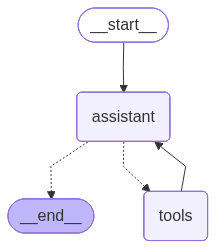

In [20]:
# Initialize LLM with tools
# llm = ChatOpenAI(
#     model=OPENAI_MODEL,
#     # We aren't sending MCP server url but tool definitions only. Thus, setting `use_responses_api` to True
#     # won't have any effect. If we had sent MCP server url, tool calling orchestration would be handled by
#     # providers like llamastack, openai e.t.c.
#     # use_responses_api=False
#     )

# Uncomment and Edit accordingly If you are Using llamastack
llm = ChatOpenAI(
    model='openai/gpt-4o',
    base_url="http://localhost:8321/v1/",
    use_responses_api=True, ## Currently, ls server throws pydantic error if this is set to True
    )

llm_with_tools = llm.bind_tools(tools)

# Define assistant node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

# Compile the graph
nps_agent = builder.compile()

# Visualize the graph
display(Image(nps_agent.get_graph(xray=True).draw_mermaid_png()))

SIDENOTE : Something similar is happening in [this](https://github.com/Nehanth/nps_agent/blob/main/agent.py) nps-agent-example that uses OpenAI's Agents SDK and `mlflow.openai.autolog()` for tracing.

Agents SDKs `agents.mcp.MCPServerSse` will only provide tool definition to llm-provider, while orchestration happens on host machine.

## Run the Agent

Invoke the agent with a query. Each graph invocation creates a trace.
Each Node (computation) in this graph creates a span. 
In our Node Logic, we can create [sub-spans](https://mlflow.org/docs/latest/genai/tracing/app-instrumentation/manual-tracing/#code-block) for a more customized span hierarchy.

In [21]:
# Run the agent
messages = [
    HumanMessage(content="Tell me about some parks in Rhode Island, and let me know if there are any upcoming events at them.")
]

response = await nps_agent.ainvoke({"messages": messages})

# Print the final response
print("\n--- Final Response ---")
print(response["messages"][-1].content)

2026/02/17 12:55:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: <Token var=<ContextVar name='current_context' default={} at 0x10f447dd0> at 0x11d2bba00> was created in a different Context
2026/02/17 12:55:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: <Token var=<ContextVar name='current_context' default={} at 0x10f447dd0> at 0x11d36b9c0> was created in a different Context
2026/02/17 12:55:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: <Token var=<ContextVar name='current_context' default={} at 0x10f447dd0> at 0x11d3dc540> was created in a different Context
2026/02/17 12:55:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: <Token var=<ContextVar name='current_context' default={} at 0x10f447dd0> at 0x11d50d400> was created in a different Context
2026/02/17 12:55:26 WARNING mlflow.utils.autologging_utils: Encounte

BadRequestError: Error code: 400 - {'error': {'detail': {'errors': [{'loc': ['body', 'input', 'str'], 'msg': 'Input should be a valid string', 'type': 'string_type'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 3, 'tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest]'], 'msg': "Input tag 'function_call_output' found using 'type' does not match any of the expected tags: 'message', 'web_search_call', 'file_search_call', 'function_call', 'mcp_call', 'mcp_list_tools', 'mcp_approval_request'", 'type': 'union_tag_invalid'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 3, 'OpenAIResponseInputFunctionToolCallOutput', 'output'], 'msg': 'Input should be a valid string', 'type': 'string_type'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 3, 'OpenAIResponseMCPApprovalResponse', 'approval_request_id'], 'msg': 'Field required', 'type': 'missing'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 3, 'OpenAIResponseMCPApprovalResponse', 'approve'], 'msg': 'Field required', 'type': 'missing'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 3, 'OpenAIResponseMCPApprovalResponse', 'type'], 'msg': "Input should be 'mcp_approval_response'", 'type': 'literal_error'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 3, 'OpenAIResponseMessage', 'content'], 'msg': 'Field required', 'type': 'missing'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 3, 'OpenAIResponseMessage', 'role'], 'msg': 'Field required', 'type': 'missing'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 3, 'OpenAIResponseMessage', 'type'], 'msg': "Input should be 'message'", 'type': 'literal_error'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 4, 'tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest]'], 'msg': "Input tag 'function_call_output' found using 'type' does not match any of the expected tags: 'message', 'web_search_call', 'file_search_call', 'function_call', 'mcp_call', 'mcp_list_tools', 'mcp_approval_request'", 'type': 'union_tag_invalid'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 4, 'OpenAIResponseInputFunctionToolCallOutput', 'output'], 'msg': 'Input should be a valid string', 'type': 'string_type'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 4, 'OpenAIResponseMCPApprovalResponse', 'approval_request_id'], 'msg': 'Field required', 'type': 'missing'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 4, 'OpenAIResponseMCPApprovalResponse', 'approve'], 'msg': 'Field required', 'type': 'missing'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 4, 'OpenAIResponseMCPApprovalResponse', 'type'], 'msg': "Input should be 'mcp_approval_response'", 'type': 'literal_error'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 4, 'OpenAIResponseMessage', 'content'], 'msg': 'Field required', 'type': 'missing'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 4, 'OpenAIResponseMessage', 'role'], 'msg': 'Field required', 'type': 'missing'}, {'loc': ['body', 'input', 'list[union[tagged-union[OpenAIResponseMessage,OpenAIResponseOutputMessageWebSearchToolCall,OpenAIResponseOutputMessageFileSearchToolCall,OpenAIResponseOutputMessageFunctionToolCall,OpenAIResponseOutputMessageMCPCall,OpenAIResponseOutputMessageMCPListTools,OpenAIResponseMCPApprovalRequest],OpenAIResponseInputFunctionToolCallOutput,OpenAIResponseMCPApprovalResponse,OpenAIResponseMessage]]', 4, 'OpenAIResponseMessage', 'type'], 'msg': "Input should be 'message'", 'type': 'literal_error'}]}}}